### Background and Motivation

2020 was a pivotal year around the world and within the context of the conversation around racial equity, justice, and equality. Specifically, in the United States, thousands of protestors and activists have taken to the streets to call for police reform and support for policies that effectively address the underlying factors that contribute to crime, poverty, and homelessness. One of the most poignant demands of these individuals has been a call for a complete reimagining of law enforcement in the United States. This project centers on one facet of this demand which is the reallocation of police budgets or more broadly “defunding the police.” What does this call entail and is there merit to considering its implementation?

Discussions of defunding the police can benefit from more knowledge of how municipal budgets are alloacted in order to get an idea of how best to utilize tax-payer money. One natural question that arises is what is the impact of various spending choices on rates of crime? That has been the guiding for this project. However it is worth noting that conversations about this topic must go further than this cursory analysis as focusing only on rates of crime risks perpetuting biases endemic of the criminal justice system. With that in that mind Let's dive in. 

In [39]:
import pandas as pd
import numpy as np
import json
import plotly.express as px
from plotly.subplots import make_subplots
from datetime import datetime as dt
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_theme(style="white")

import warnings
warnings.filterwarnings("ignore")  # Suppress all warnings

### Datasets

To conduct this analysis we’ve selected three primary datasets for our investigation which we briefly outline below. 
1. FBI-Crime Dataset
    - This dataset lists rates of crime by Metropolitan Statistical Area each year. We focused on the years 2010- 2017 (Limited by the ACS). Other years are available at the source.
2. FISC Dataset
    - The FiSC dataset makes it possible to compare local government finances for 150 of the largest U.S. cities across more than 125 categories of revenues, expenditures, debt, and assets, with annual data going back to 1977.
3. American Community Survey (ACS) colelcted by the census bureau
    - This dataset contains a wealth of information. Notably, population, demographic and housing unit estimates.


### Data Cleaning

The FISC dataset is the most structured of all the datasets so in terms of cleaning it was not that involved.

The FiSC database was constructed using information from the individual unit of government files produced by the
Governments Division of the U.S. Census Bureau. In the dataset, all values are expressed in real per capita dollars ($2017). However, it is possible to convert to nominal dollars (Not adjusted for inflation) and/or total dollars (Not adjusted for population changes) by using variables in the dataset for City Population (Column D) and/or the Consumer Price Index (Column E).
The conversion can be done as follows:
- Real Total Dollars = (Fiscal Variable) x (City Population)
- Nominal Per Capita Dollars = (Fiscal Variable) / (CPI)
- Nominal Total Dollars = [(Fiscal Variable) x (City Population)] / (CPI)


#### FBI Cleaning

This dataset was more challenging to clean as the data represented not only core cities
but outlying metropolitan areas as well. The first challenge was related to the way that city names were recorded. Some of the city names had multiple state names and sublocations depending on where the data was recorded. This reality conflicted with the way names were recorded in the FISC data set. To obtain city names, we decided to isolate just the core cities for each municipality on the list and not incorporate any potential outlying areas. For example the Metropolitan area for Memphis, TN also included areas in North Mississippi and Arkansas. However, since Memphis is the major city, this was the value we decided to keep. We decided to keep only the first state assigned to each city. 


**Before:**

In [40]:
file_str = "data/crime_data/FBI_Crime_{}.xls"
df = pd.read_excel(file_str.format(2000), header = 4)
df.head()

,"Abilene, TX M.S.A.",127413,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,(Includes Taylor County.),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,City of Abilene,113387,4797,NaN,404,4393,1,43,105,255,960,3203,230,NaN,NaN
2,Total area actually reporting,1,5142,NaN,437,4705,1,52,107,277,1044,3419,242,NaN,NaN
3,"Rate per 100,000 inhabitants",NaN,4035.7,NaN,343,3692.7,0.8,40.8,84,217.4,819.4,2683.4,189.9,,NaN
4,"Albany, GA M.S.A.",123424,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**After:**
This process was involved and is contained in a seperate notebook

In [41]:
test_df = pd.read_csv('CleanData/FBI_Crime.csv')
test_df[['city_fbi','violent_crime','property_crime','year']].head()

,city_fbi,violent_crime,property_crime,year
0,"Abilene, TX",343,3692.7,2000
1,"Albany, GA",497.5,4993.4,2000
2,"Albany, NY",309.1,2882.1,2000
3,"Albuquerque, NM",945.7,6093.1,2000
4,"Alexandria, LA",690.7,6209.8,2000


#### ACS Cleaning

Cleaning of the ACS was just as involved as cleaning the FBI data. Primarily because the survey has changed over the years. For example there are additions of racial categories, redactions of previously collected data. 

**Before:**

In [42]:
file_str = "data/demographics/Race{}.csv".format(2010)
temp_df = pd.read_csv(file_str, skiprows = 1)
temp_df.head()

,id,Geographic Area Name,Estimate!!SEX AND AGE!!Total population,Estimate Margin of Error!!SEX AND AGE!!Total population,Percent!!SEX AND AGE!!Total population,Percent Margin of Error!!SEX AND AGE!!Total population,Estimate!!SEX AND AGE!!Male,Estimate Margin of Error!!SEX AND AGE!!Male,Percent!!SEX AND AGE!!Male,Percent Margin of Error!!SEX AND AGE!!Male,...,Percent Margin of Error!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or more races!!Two races including Some other race,"Estimate!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or more races!!Two races excluding Some other race, and Three or more races","Estimate Margin of Error!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or more races!!Two races excluding Some other race, and Three or more races","Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or more races!!Two races excluding Some other race, and Three or more races","Percent Margin of Error!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or more races!!Two races excluding Some other race, and Three or more races",Estimate!!Total housing units,Estimate Margin of Error!!Total housing units,Percent!!Total housing units,Percent Margin of Error!!Total housing units,Estimate!!RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Guamanian or Chamorro
0,310M100US10140,"Aberdeen, WA Micro Area",72882,*****,72882,(X),37419,681,51.3,0.9,...,0.2,2330,884,3.2,1.2,35179,446,(X),(X),N
1,310M100US10180,"Abilene, TX Metro Area",164941,1357,164941,(X),82694,1106,50.1,0.5,...,0.1,3303,1034,2.0,0.6,69711,1296,(X),(X),N
2,310M100US10300,"Adrian, MI Micro Area",99763,*****,99763,(X),50213,863,50.3,0.9,...,0.1,1872,607,1.9,0.6,43445,701,(X),(X),N
3,310M100US10380,"Aguadilla-Isabela-San Sebasti?n, PR Metro Area",305988,*****,305988,(X),149560,1804,48.9,0.6,...,0.1,516,462,0.2,0.2,143248,2349,(X),(X),N
4,310M100US10420,"Akron, OH Metro Area",702951,*****,702951,(X),341630,940,48.6,0.1,...,0.1,15717,2715,2.2,0.4,312600,1589,(X),(X),N


**After:**

In [43]:
temp_df = pd.read_csv('CleanData/Race.csv')
temp_df.set_index('geographic_area_name').head()

,percent_race_one_race_asian,percent_race_one_race_black_or_african_american,percent_race_one_race_native_hawaiian_and_other_pacific_islander,percent_race_one_race_white,Year,percent_hispanic_or_latino
geographic_area_name,,,,,,
"Aberdeen, WA",1.8,1.1,0.1,84.4,2010,8.7
"Abilene, TX",1.0,7.5,0.0,84.3,2010,21.3
"Adrian, MI",0.4,2.1,0.0,93.2,2010,7.6
"Aguadilla, PR",0.0,2.7,0.0,87.3,2010,97.3
"Akron, OH",1.9,11.7,0.0,83.3,2010,1.5


## Final Dataset

Once each dataset was cleaned we combined them together to form the dataset that would inform our analysis. The resulting dataset can be seen below

In [44]:
df = pd.read_csv('dash/data/CleanDataScatter.csv')
df.head()

,City,Population,Year,Violent Crime,Property Crime,Total Revenue,Police Spending,Education Services,Education,Higher Education,...,Population over 65 Years of Age,Percent of Individuals Below Poverty (Ages 18-64),Asian Population (%),Black/African-American Population (%),Hawaiian and Other Pacific Islander Population (%),White Population (%),Hispanic or Latino Population (%),Group,Latitude,Longitude
0,"San Antonio, TX",2187591,2011,398.1,4667.6,6585.16,288.30,1944.09,1918.27,0.0,...,4.914281e-08,14.6,2.0,6.3,0.1,78.0,54.2,1,29.463401,-98.496651
1,"San Antonio, TX",2426076,2016,526.4,4081.9,6854.55,288.66,1903.70,1879.07,0.0,...,5.081270e-08,13.5,2.5,6.9,0.1,80.0,55.1,1,29.463401,-98.496651
2,"San Antonio, TX",2104901,2010,484.0,5233.1,6430.39,293.59,2188.31,2162.26,0.0,...,4.934863e-08,14.0,2.0,6.4,0.1,77.8,54.2,1,29.463401,-98.496651
3,"San Antonio, TX",2227800,2012,390.7,4688.1,6303.52,280.46,1811.56,1785.63,0.0,...,5.030711e-08,14.9,2.2,6.5,0.1,77.4,54.4,1,29.463401,-98.496651
4,"San Antonio, TX",2271017,2013,459.7,4415.2,6770.40,275.07,1888.32,1862.46,0.0,...,5.059259e-08,14.6,2.2,6.5,0.1,81.1,54.5,1,29.463401,-98.496651


# EDA

Initial analysis for over 100 cities during 2010 - 2017 found that police budget did not have a direct impact  on crime rate. On a national level we can see that median police spending per capita and median crime rate appear to move in a synchronous fashion. 


In [45]:
average_crime_per_year = df.groupby('Year').mean().reset_index()
subfig2 = make_subplots(specs=[[{"secondary_y": True}]])
fig5 = px.line(average_crime_per_year, x="Year", y=["Violent Crime"],labels={"Violent Crime": "Violent Crime"})
fig5.update_traces(line_color='rgb(204, 102, 119)',name="Violent Crime")
fig6 = px.line(average_crime_per_year, x="Year", y=["Police Spending"],labels={"Police Spending": "Police Spending"})
fig6.update_traces(line_color='rgb(95, 70, 144)',name="Police Spending")
fig6.update_traces(yaxis="y2")
fig6.update_layout(showlegend=True)
subfig2.add_traces(fig5.data + fig6.data)
subfig2.layout.xaxis.title="Year"
subfig2.layout.yaxis.title="Violent Crime (Rate per 100,00)"
subfig2.layout.yaxis2.title="Police Spending"
subfig2.layout.paper_bgcolor='#F8F9F9'
subfig2.show()

Our exploratory analysis found that the employment status of the civilian labor force age 16 and above appeared to have an impact on violent crime rate.


In [46]:
subfig = make_subplots(specs=[[{"secondary_y": True}]])
fig5 = px.line(average_crime_per_year, x="Year", y=["Violent Crime"],labels={"Violent Crime": "Violent Crime"})
fig5.update_traces(line_color='rgb(204, 102, 119)',name="Violent Crime")
fig6 = px.line(average_crime_per_year, x="Year", y=["Percent Labor Force (Age 16 and Over)"],labels={"Percent Labor Force (Age 16 and Over)": "Percent Labor Force (Age 16 and Over)"})
fig6.update_traces(line_color='rgb(95, 70, 144)',name="Labor Force")
fig6.update_traces(yaxis="y2")
fig6.update_layout(showlegend=True)
subfig.add_traces(fig5.data + fig6.data)
subfig.layout.xaxis.title="Year"
subfig.layout.yaxis.title="Violent Crime (Rate per 100,00)"
subfig.layout.yaxis2.title="Percent Labor Force (Age 16 and Over)"
subfig.show()

### Clustering

In [47]:
distortions = [5.70018975096815,
 5.3917719469910335,
 5.207612323944026,
 5.022429564912141,
 4.864104706107141,
 4.704610997188345,
 4.563223420060094,
 4.442719686601922,
 4.345430839998032,
 4.255879105956352,
 4.182172270829216,
 4.090898740951057,
 4.031403673785274,
 3.9768212227529958]

inertias = [31239.00000000004,
 27775.765436503872,
 24608.998403928646,
 22668.826596544495,
 20987.144128504726,
 19739.850540716492,
 18570.718685254138,
 17625.6584272275,
 16833.777981684838,
 16043.102484623061,
 15307.681015115815,
 14740.492585233238,
 14240.807607247105,
 13813.956264279239]

K = list(range(1,15))

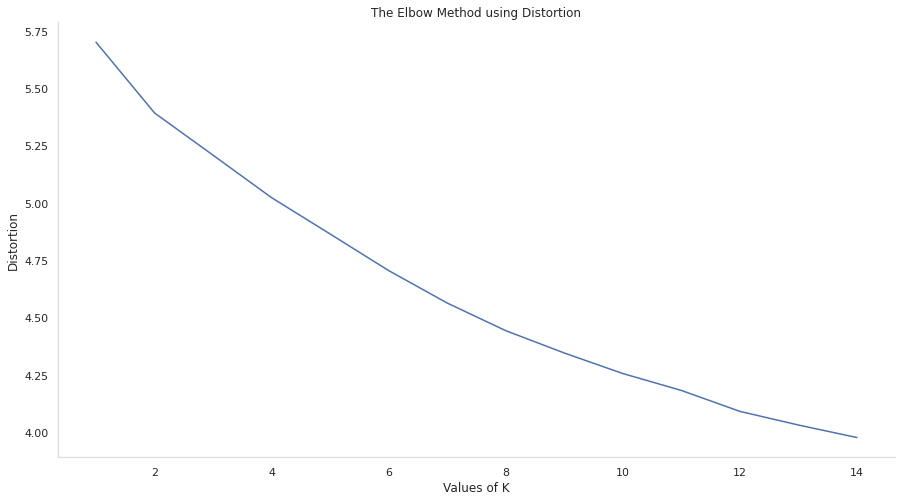

In [48]:
plt.figure(figsize=(15,8))

ax = sns.lineplot(K,distortions)
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

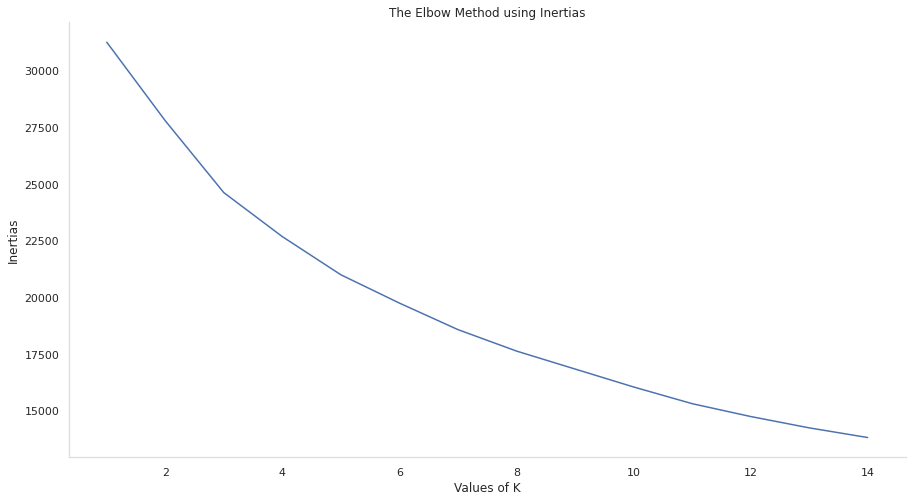

In [49]:
plt.figure(figsize=(15,8))

ax = sns.lineplot(K,inertias)
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
plt.xlabel('Values of K') 
plt.ylabel('Inertias') 
plt.title('The Elbow Method using Inertias') 
plt.show() 

#### Exploring The Clusters

In [75]:
df[['Group','City']].drop_duplicates().groupby('Group').head(10)

,Group,City
0,1,"San Antonio, TX"
7,1,"Houston, TX"
12,1,"Lubbock, TX"
19,1,"Springfield, MA"
27,1,"Shreveport, LA"
32,1,"New Orleans, LA"
38,1,"Corpus Christi, TX"
45,1,"Flint, MI"
53,1,"Detroit, MI"
61,1,"Wichita, KS"


In [50]:
by_group = df.groupby(['Year','Group']).mean().reset_index()
by_group['Group'] = by_group['Group'].astype(str) 


# bar plot of violent crime
fig = px.bar(by_group, x="Year", y="Violent Crime",color='Group')
fig.update_layout(barmode='group',title='',plot_bgcolor='#F8F9F9')
fig.show()

In [51]:
df['Group'] = df['Group'].apply(str) 
fig3 = px.scatter_geo(df,
                    lat="Latitude",
                    lon="Longitude",
                    hover_name="City",
                    projection="albers usa",
                    color="Group",
                    size="Violent Crime",
                    hover_data=['City','Violent Crime','Property Crime','Police Spending','Total Revenue'])

fig3.update_layout(
        title = 'Metropolitan Areas by Cluster Label'
)
fig3.show()

In [52]:
df['Group'] = df['Group'].apply(str) 
fig2 = px.scatter(df.sort_values(by='Group'), x="Police Spending", y="Violent Crime",color='Group',hover_data=['City','Violent Crime','Police Spending','Population'])
fig2.show()

In [53]:
df['Group'] = df['Group'].apply(str) 
fig2 = px.scatter(df.sort_values(by='Group'), x="Police Spending", y="Property Crime",color='Group',hover_data=['City','Violent Crime','Police Spending','Population'])
fig2.show()

### Correlations

Definitions

In [54]:
# relevant variables 
relevant_variables = ["Police Spending",
'Percent Below Poverty (65 Years and Over)',
 'Percent Below Poverty (Worked Full-Time Past Twelve Months)',
 'Percent Inviduals Below Poverty Line (under 18)',
 'Percent Inviduals For Whom Poverty Status is Determined',
 'Percent of Individuals Under 18 Years of Age',
 'Percent of Individuals Below Poverty (Ages 18-64)',
 'Housing and Community Development',
 'Per Capita Personal Income Dollars',
 'Personal Income Thousands of Dollars',
 'Percent Educational Attainment (25 years and over)',
 'Percent of Individuals Aged 18-64',
 'Percent Labor Force (Age 16 and Over)']

vc_n = ['Housing and Community Development',
 'Per Capita Personal Income Dollars',
 'Percent Educational Attainment (25 years and over)',
 'Percent of Individuals Aged 18-64',
 'Percent Labor Force (Age 16 and Over)']

vc_p = ['Percent Inviduals Below Poverty Line (under 18)',
 'Percent Inviduals For Whom Poverty Status is Determined',
 'Percent of Individuals Below Poverty (Ages 18-64)',
 'Percent Below Poverty (65 Years and Over)',
 'Percent Below Poverty (Worked Full-Time Past Twelve Months)']

# Property Crime Positive Correlations 
pc_p = ['Percent Below Poverty (65 Years and Over)',
 'Percent Below Poverty (Worked Full-Time Past Twelve Months)',
 'Percent Inviduals Below Poverty Line (under 18)',
 'Percent Inviduals For Whom Poverty Status is Determined',
 'Population over 65 Years of Age',
 'Percent of Individuals Below Poverty (Ages 18-64)']

pc_n = ['Population',
 'Total Revenue',
 'Police Spending',
 'Education Services',
 'Education',
 'Higher Education',
 'Education (Elementary and Secondary)',
 'Social Services',
 'Public Welfare',
 'Welfare Vendors',
 'Welfare Other',
 'Correction',
 'Parks Recreation',
 'Housing and Community Development',
 'Per Capita Personal Income Dollars',
 'Personal Income Thousands of Dollars',
 'Population (ACS Estimate)',
 'Percent Educational Attainment (25 years and over)',
 'Percent of Individuals Aged 18-64',
 'Percent Labor Force (Age 16 and Over)',
 'Mean Income Deficit ($)']

races = ['Asian Population (%)',
 'Black/African-American Population (%)',
 'Hawaiian and Other Pacific Islander Population (%)',
 'White Population (%)',
 'Hispanic or Latino Population (%)']

In [55]:
# Correlation  Summarized Plot
corrs = df[vc_p+vc_n+['Violent Crime','Property Crime','Group']].groupby("Group").median().corr()
disp = corrs[['Property Crime', 'Violent Crime']].iloc[0:-2].sort_values(by='Property Crime',ascending=False)
fig7 = px.imshow(disp)
fig7.update_layout(
    paper_bgcolor='#F8F9F9',
    height=700
)
fig7.show()

In [56]:
race_analysis = []
for i in range(len(races)):
    race_melt = df[vc_p+vc_n+['Group']+races[i:i+1]].corr()
    race_analysis.append(race_melt[races[i:i+1]].iloc[:-2])


race_analysis = pd.concat(race_analysis,axis=1)
fig9 = px.imshow(race_analysis)
fig9.update_layout(
    autosize=True,
    height=600,
    paper_bgcolor='#F8F9F9'
)
fig9.show()

### Statistical Testing

In [57]:
import statsmodels.formula.api as sm

We choose to eliminate Washington, DC from our analysis. Washington DC, is unique. There are very few cities that exhibit similar trends. This can be seen from the clustering analysis where it was grouped by itself.

In [58]:
regress = df[df['City']!='Washington, DC']
regress['Violent Crime'] = regress['Violent Crime'] * (10**-5)
regress['Property Crime'] = regress['Property Crime'] * (10**-5)
regress

,City,Population,Year,Violent Crime,Property Crime,Total Revenue,Police Spending,Education Services,Education,Higher Education,...,Population over 65 Years of Age,Percent of Individuals Below Poverty (Ages 18-64),Asian Population (%),Black/African-American Population (%),Hawaiian and Other Pacific Islander Population (%),White Population (%),Hispanic or Latino Population (%),Group,Latitude,Longitude
0,"San Antonio, TX",2187591,2011,0.003981,0.046676,6585.16,288.30,1944.09,1918.27,0.0,...,4.914281e-08,14.6,2.0,6.3,0.1,78.0,54.2,1,29.463401,-98.496651
1,"San Antonio, TX",2426076,2016,0.005264,0.040819,6854.55,288.66,1903.70,1879.07,0.0,...,5.081270e-08,13.5,2.5,6.9,0.1,80.0,55.1,1,29.463401,-98.496651
2,"San Antonio, TX",2104901,2010,0.004840,0.052331,6430.39,293.59,2188.31,2162.26,0.0,...,4.934863e-08,14.0,2.0,6.4,0.1,77.8,54.2,1,29.463401,-98.496651
3,"San Antonio, TX",2227800,2012,0.003907,0.046881,6303.52,280.46,1811.56,1785.63,0.0,...,5.030711e-08,14.9,2.2,6.5,0.1,77.4,54.4,1,29.463401,-98.496651
4,"San Antonio, TX",2271017,2013,0.004597,0.044152,6770.40,275.07,1888.32,1862.46,0.0,...,5.059259e-08,14.6,2.2,6.5,0.1,81.1,54.5,1,29.463401,-98.496651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,"Gulfport, MS",238426,2010,0.002219,0.043104,11141.86,508.12,1554.24,1533.66,0.0,...,1.971919e-07,16.6,2.5,19.5,0.0,74.0,5.1,6,30.414469,-89.074232
797,"Gulfport, MS",249760,2011,0.002254,0.040066,11658.37,464.57,1320.16,1296.99,0.0,...,1.968016e-07,19.3,2.6,19.8,0.0,74.6,4.9,6,30.414469,-89.074232
798,"Gulfport, MS",382406,2013,0.002837,0.036249,10168.04,356.72,1518.71,1481.36,0.0,...,3.236408e-07,17.1,2.5,21.6,0.0,72.6,5.2,6,30.414469,-89.074232
799,"Gulfport, MS",388848,2015,0.002333,0.037074,10061.91,347.01,1386.60,1369.94,0.0,...,3.372532e-07,18.9,2.6,21.4,0.0,71.2,5.5,6,30.414469,-89.074232


### We need to remove spaces and special characters to do the regression

In [59]:

regress_vars = {'Percent Inviduals Below Poverty Line (under 18)':
                               'youth_poverty','Hawaiian and Other Pacific Islander Population (%)':'percent_hawaiian',
                               'Mean Income Deficit ($)': 'income_deficit',
                               'Percent Educational Attainment (25 years and over)':'educational_attainment', 
                               'Percent of Total Workforce (16 years and over)': 'estimate_employed', 
                               'Black/African-American Population (%)':'percent_black',
                               'Violent Crime':'violent_crime',
                               'Total Revenue':'rev_total',
                               'Public Welfare':'public_welfare',
                                'Welfare Cash':'welfare_cash',
                                'Correction':'correction',
                                'Housing and Community Development':'housing_commdevt',   
                                'Percent of Individuals Under 18 Years of Age':'total_estimate_age_under_18_years',
                                'Percent Male Population':'total_estimate_sex_male',
                                'Population over 65 Years of Age':'total_estimate_age_65_years_and_over',
                                'Asian Population (%)':'percent_race_one_race_asian',  
                                'White Population (%)':'percent_race_one_race_white',
                                'Hispanic or Latino Population (%)':'percent_hispanic_or_latino',
                                'Police Spending':'police_spending'}
regress= regress.rename(columns=regress_vars)
regress_names = {value:key for key, value in regress_vars.items()}

### Perform Regression with Variables Obtained from Correlation Analysis

In [60]:
model1 = 'violent_crime ~ rev_total + public_welfare + welfare_cash + correction +housing_commdevt  + youth_poverty +  estimate_employed + income_deficit + total_estimate_age_under_18_years + total_estimate_sex_male + total_estimate_age_65_years_and_over + percent_race_one_race_asian + percent_black +percent_hawaiian + percent_race_one_race_white + percent_hispanic_or_latino ' 
lm1   = sm.ols(formula = model1, data = regress).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:          violent_crime   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     33.35
Date:                Thu, 11 Feb 2021   Prob (F-statistic):           3.57e-77
Time:                        17:50:45   Log-Likelihood:                 4115.0
No. Observations:                 793   AIC:                            -8196.
Df Residuals:                     776   BIC:                            -8117.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


### Adding in Police Spending Doesn't Make a meaninful difference

In [61]:
model1 = 'violent_crime ~ rev_total + public_welfare + welfare_cash + correction +housing_commdevt  + youth_poverty +  estimate_employed + income_deficit + total_estimate_age_under_18_years + total_estimate_sex_male + total_estimate_age_65_years_and_over + percent_race_one_race_asian + percent_black +percent_hawaiian + percent_race_one_race_white + percent_hispanic_or_latino +police_spending ' 
lm1   = sm.ols(formula = model1, data = regress).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:          violent_crime   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     32.60
Date:                Thu, 11 Feb 2021   Prob (F-statistic):           4.75e-79
Time:                        17:50:46   Log-Likelihood:                 4121.4
No. Observations:                 793   AIC:                            -8207.
Df Residuals:                     775   BIC:                            -8123.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


To interact with our dashboard visit the following [link](https://ds4a-team7.herokuapp.com/)

### Making Predictions with the Regression Model

In [62]:
noDC = regress
noDC['Fits']= 4.662918e-03+ noDC['rev_total']*1.699413e-07
+ noDC['public_welfare']*-2.784823e-06 + noDC['welfare_cash']*3.215736e-06 
+noDC['correction']*-3.820413e-06 + noDC['housing_commdevt']*-1.767486e-06 
+ noDC['youth_poverty']*7.044471e-05 
+noDC['estimate_employed']*-1.596820e-02 +noDC["income_deficit"]*-2.441968e-07
+ noDC["total_estimate_age_under_18_years"]*-3.196742e-02+ noDC["total_estimate_sex_male"]*4.768845e-02
+ noDC["total_estimate_age_65_years_and_over"]*-1.251370e+03+noDC["percent_race_one_race_asian"]*-6.814841e-05
+ noDC["percent_black"]*3.520207e-05+noDC["percent_hawaiian"]*1.294790e-03+ noDC["percent_race_one_race_white"] * -4.546245e-05+noDC["percent_hispanic_or_latino"] * 1.482309e-05

0     -0.002391
1     -0.002448
2     -0.002379
3     -0.002354
4     -0.002521
         ...   
796   -0.002602
797   -0.002622
798   -0.002463
799   -0.002402
800   -0.002253
Length: 793, dtype: float64

In [63]:
def reapply_names(row):
    if row in list(regress_vars.values()):
        return regress_names[row]
    else:
        return row

In [64]:
noDC = noDC.rename(columns=lambda x: reapply_names(x))
noDC[['Violent Crime','Fits']]

,Violent Crime,Fits
0,0.003981,0.005782
1,0.005264,0.005828
2,0.004840,0.005756
3,0.003907,0.005734
4,0.004597,0.005813
...,...,...
796,0.002219,0.006556
797,0.002254,0.006644
798,0.002837,0.006391
799,0.002333,0.006373


In [65]:
color_discrete_map = {"1":'#636EFA',"2":'#EF553B',"3":'#00CC96',"4":'#AB63FA',"5":'#FFA15A',"6":'#19D3F3'}
px.scatter(noDC, y='Violent Crime', x='Fits', trendline="ols",color = "Group",color_discrete_map=color_discrete_map)

In [66]:
### Testing Across Different Levels of Crime

In [67]:
def classify_crime(row):
    high = 0.005297
    low = 0.002997
    row = float(row)
    if row > high:
        return 'high'
    elif row < low:
        return 'low'
    else: 
        return 'avg'
    

In [68]:
noDC['crime_level']=noDC['Violent Crime'].apply(classify_crime)
noDC= noDC.rename(columns=regress_vars)


### Poverty rates are significantly different across all levels, with High crime having the highest poverty levels

In [69]:
from scipy import stats
gb = noDC.groupby(['crime_level'])
group_names = noDC["crime_level"].unique()
print("\t\t\tstatistic\t\tpvalue")
for i in range(len(group_names)):
    for j in range(i+1, len(group_names)):
        group1 = gb[["youth_poverty"]].get_group(group_names[i]).astype('float')
        group2 = gb[["youth_poverty"]].get_group(group_names[j]).astype('float')
        stat, pvalue = stats.ttest_ind(group1, group2, equal_var = False)
        print(str(group_names[i]) + " vs. " + str(group_names[j]) + "\t" + str(stat[0]) + "\t" + str(pvalue[0]))

			statistic		pvalue
avg vs. high	-4.826915292933586	2.0214206112195143e-06
avg vs. low	7.2603021527152904	2.3062894082776387e-12
high vs. low	10.264972568164453	4.594471681666674e-22


### Education spending is different between high /low and avg/low but now high/avg

In [37]:
gb = noDC.groupby(['crime_level'])
group_names = noDC['crime_level'].unique()
print("\t\t\tstatistic\t\tpvalue")
for i in range(len(group_names)):
  for j in range(i+1, len(group_names)):
    group1 = gb[['Education Services']].get_group(group_names[i]).astype('float')
    group2 = gb[['Education Services']].get_group(group_names[j]).astype('float')
    stat, pvalue = stats.ttest_ind(group1, group2, equal_var = False)
    print(str(group_names[i]) + " vs. " + str(group_names[j]) + "\t" + str(stat[0]) + "\t" + str(pvalue[0]))

			statistic		pvalue
avg vs. high	1.1683371896991899	0.2432714566259384
avg vs. low	-2.7427195997515357	0.006463466334982649
high vs. low	-3.4165075651366865	0.000716827764599195


### Social services are only significantly different between the high/avg levels

In [38]:
gb = noDC.groupby(['crime_level'])
group_names = noDC['crime_level'].unique()
print("\t\t\tstatistic\t\tpvalue")
for i in range(len(group_names)):
    for j in range(i+1, len(group_names)):
        group1 = gb[['Social Services']].get_group(group_names[i]).astype('float')
        group2 = gb[['Social Services']].get_group(group_names[j]).astype('float')
        stat, pvalue = stats.ttest_ind(group1, group2, equal_var = False)
        print(str(group_names[i]) + " vs. " + str(group_names[j]) + "\t" + str(stat[0]) + "\t" + str(pvalue[0]))

			statistic		pvalue
avg vs. high	-2.453987174495712	0.014716758546041847
avg vs. low	-1.8124937648844082	0.0710326939336807
high vs. low	0.30497944278590644	0.7605459101810276


### Income deficit is different amongst all levels, with high crime areas having the highest income deficit

In [87]:
gb = noDC.groupby(['crime_level'])
group_names = noDC['crime_level'].unique()
print("\t\t\tstatistic\t\tpvalue")
for i in range(len(group_names)):
    for j in range(i+1, len(group_names)):
        group1 = gb[['income_deficit']].get_group(group_names[i]).astype('float')
        group2 = gb[['income_deficit']].get_group(group_names[j]).astype('float')
        stat, pvalue = stats.ttest_ind(group1, group2, equal_var = False)
        print(str(group_names[i]) + " vs. " + str(group_names[j]) + "\t" + str(stat[0]) + "\t" + str(pvalue[0]))

			statistic		pvalue
avg vs. high	-2.363117098490166	0.018623244284324707
avg vs. low	2.467948706284247	0.014077690829774498
high vs. low	4.048751294743625	6.218943357404763e-05


### Poverty rates are significantly different across all levels, with High crime having the highest poverty levels.

In [96]:
gb = noDC.groupby(['crime_level'])
group_names = noDC["crime_level"].unique()
print("\t\t\tstatistic\t\tpvalue")
for i in range(len(group_names)):
    for j in range(i+1, len(group_names)):
        group1 = gb[["police_spending"]].get_group(group_names[i]).astype('float')
        group2 = gb[["police_spending"]].get_group(group_names[j]).astype('float')
        stat, pvalue = stats.ttest_ind(group1, group2, equal_var = False)
        print(str(group_names[i]) + " vs. " + str(group_names[j]) + "\t" + str(stat[0]) + "\t" + str(pvalue[0]))

			statistic		pvalue
avg vs. high	-2.811858630449221	0.005173391367453448
avg vs. low	1.3083964579321605	0.19152822401511646
high vs. low	3.526459769531022	0.00047077602320669


# Final Recomendations

Our data suggests that higher spending on policing does not, on its own merit, result in lower crime rates. In fact, our data indicates that the cities with the highest police spending actually have higher violent crime rates. This does not mean policing causes crime, but does suggest its role in preventing crime is limited. Our analysis suggests that policing is not a proactive measure that improves the lives of residents, but instead is a reactive measure, with cities increasing police budgets to address crime when that may not be the most effective option. The analysis performed for this report indicates that efforts to reduce poverty, provide social service support to residents, and increase educational attainment of citizens would be more impactful than simply increasing police budgets. While our analysis did not provide strong enough evidence to develop a causal model, it does indicate that the aforementioned variables correlate more strongly, and in the case of poverty rates much more strongly, than police spending. 